In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Concatenate, Average, Maximum, CuDNNLSTM, CuDNNGRU, Bidirectional, TimeDistributed
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine.input_layer import Input
from keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(7723)
tf.set_random_seed(1090)

Using TensorFlow backend.


In [2]:
%%time
train_df = pd.read_csv('../input/train/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

CPU times: user 2min 20s, sys: 6.94 s, total: 2min 27s
Wall time: 2min 27s


In [3]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [4]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [5]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


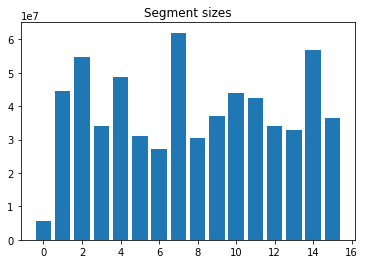

In [6]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std
        x_batch_result = np.expand_dims(x_batch, axis=2)
        print("x_batch_result.shape:", x_batch_result.shape)
        print("y_batch.shape:", y_batch.shape)
        return x_batch_result, y_batch

In [7]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std
        x_batch_result = np.expand_dims(x_batch, axis=2)
        return x_batch_result, y_batch

We could use any segments for training / validation

In [8]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [9]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [10]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

Use convolutional layers to learn the features and reduce the time sequence length 

In [11]:
def CnnRnnModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = CuDNNGRU(24, return_sequences = False, return_state = False)(x)
    y = Dense(1)(x)

    return Model(inputs = [i], outputs = [y])

In [12]:
model = CnnRnnModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150000, 1)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15000, 8)          88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1500, 16)          1296      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 150, 16)           2576      
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 24)                3024      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 7,009
Trainable params: 7,009
Non-trainable params: 0
_________________________________________________________________


Train the model with early stopping

In [1]:
%%time
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 50, 
    verbose = 1, 
    validation_data = valid_gen,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience = 5, verbose = 1),
        ModelCheckpoint(filepath='cnn_rnn.h5', monitor='val_loss', save_best_only=True, verbose=1)]
)

NameError: name 'model' is not defined

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [ ]:
def load_test(ts_length = 150000):
    base_dir = '../input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

Load and normalize the test data

In [ ]:
test_data, test_ids = load_test()

In [ ]:
X_test = ((test_data - X_train_mean)/ X_train_std).astype('float32')
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
model = load_model('cnn_rnn.h5')

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)

x_batch_result.shape: (64, 150000, 1)
y_batch.shape: (64,)

(array([[[-1.3689240219689038 ],
         [-1.3689240219689038 ],
         [-0.5610408316625461 ],
         ...,
         [-0.5610408316625461 ],
         [-0.7226174697238177 ],
         [-0.5610408316625461 ]],
 
        [[ 0.8931489108888979 ],
         [ 0.7315722728276264 ],
         [-0.23788755554000302],
         ...,
         [ 0.40841899670508325],
         [ 0.40841899670508325],
         [-0.07631091747873145]],
 
        [[ 0.40841899670508325],
         [ 0.08526572058254012],
         [ 0.7315722728276264 ],
         ...,
         [ 3.1552218437466997 ],
         [ 3.1552218437466997 ],
         [ 2.8320685676241566 ]],
 
        ...,
 
        [[ 0.24684235864381168],
         [ 0.08526572058254012],
         [ 0.8931489108888979 ],
         ...,
         [-0.39946419360127455],
         [-0.7226174697238177 ],
         [-1.3689240219689038 ]],
 
        [[-0.23788755554000302],
         [ 0.5699956347663548 ],
         [ 0.5699956347663548 ],
         ...,
         [ 0.40841899670508325],
         [-0.07631091747873145],
         [-0.07631091747873145]],
 
        [[-0.07631091747873145],
         [ 0.08526572058254012],
         [-0.5610408316625461 ],
         ...,
         [ 0.7315722728276264 ],
         [ 0.40841899670508325],
         [ 0.24684235864381168]]]),
 array([ 9.323896408081055 ,  8.34179973602295  ,  7.8024001121521   ,
         4.6880974769592285,  4.602997779846191 ,  4.981696605682373 ,
         1.3641964197158813,  8.554596900939941 ,  1.6609961986541748,
         2.2642955780029297,  8.26949691772461  ,  8.812098503112793 ,
         3.6591973304748535,  7.3990983963012695,  2.2940971851348877,
         5.358396530151367 ,  8.258795738220215 , 10.368698120117188 ,
         8.600399017333984 ,  8.738697052001953 , 10.477296829223633 ,
         7.1937994956970215, 10.30379867553711  , 10.925196647644043 ,
         2.7781989574432373,  8.13119888305664  ,  2.415395736694336 ,
         5.555197238922119 ,  1.0768991708755493, 10.019699096679688 ,
         9.593098640441895 , 10.436796188354492 , 10.173995971679688 ,
         3.807098865509033 ,  9.5281982421875   ,  7.993897438049316 ,
         5.887199878692627 ,  2.7824974060058594,  7.440596580505371 ,
         1.5800968408584595,  2.4866974353790283,  8.032197952270508 ,
         8.76209831237793  ,  5.973397731781006 ,  3.639995813369751 ,
         7.053299427032471 ,  3.829397678375244 ,  4.1326985359191895,
         6.6468963623046875,  1.0555974245071411,  9.188796997070312 ,
         0.0958956703543663,  2.510098695755005 ,  1.4470993280410767,
         1.4726964235305786,  8.66529655456543  ,  4.5113983154296875,
        10.063399314880371 ,  2.1333987712860107,  7.150198936462402 ,
         3.037799835205078 ,  5.281799793243408 ,  0.9789979457855225,
         1.9524978399276733]))

Use convolutional layers to learn the features and reduce the time sequence length
